## Naive Bayes


Original Data Sample:
           Company Name       Location  \
0  disability solutions   glendale, ca   
1  disability solutions   glendale, ca   
2    belmont university  nashville, tn   
3    belmont university  nashville, tn   
4   beck's hybrids\n4.6    atlanta, in   

                                       Job Title    job_category  python_yn  \
0                          advanced data analyst    Data Analyst        0.0   
1                          advanced data analyst    Data Analyst        0.0   
2  advancement services - temporary data analyst    Data Analyst        0.0   
3  advancement services – temporary data analyst    Data Analyst        0.0   
4                              ag data scientist  Data Scientist        0.0   

   R_yn  spark  aws  excel  avg_salary  
0   0.0    0.0  0.0    1.0    117500.0  
1   0.0    0.0  0.0    1.0    117500.0  
2   0.0    0.0  0.0    1.0    117500.0  
3   0.0    0.0  0.0    1.0    117500.0  
4   0.0    0.0  0.0    0.0    167440.0  

Be

c:\Users\shiva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


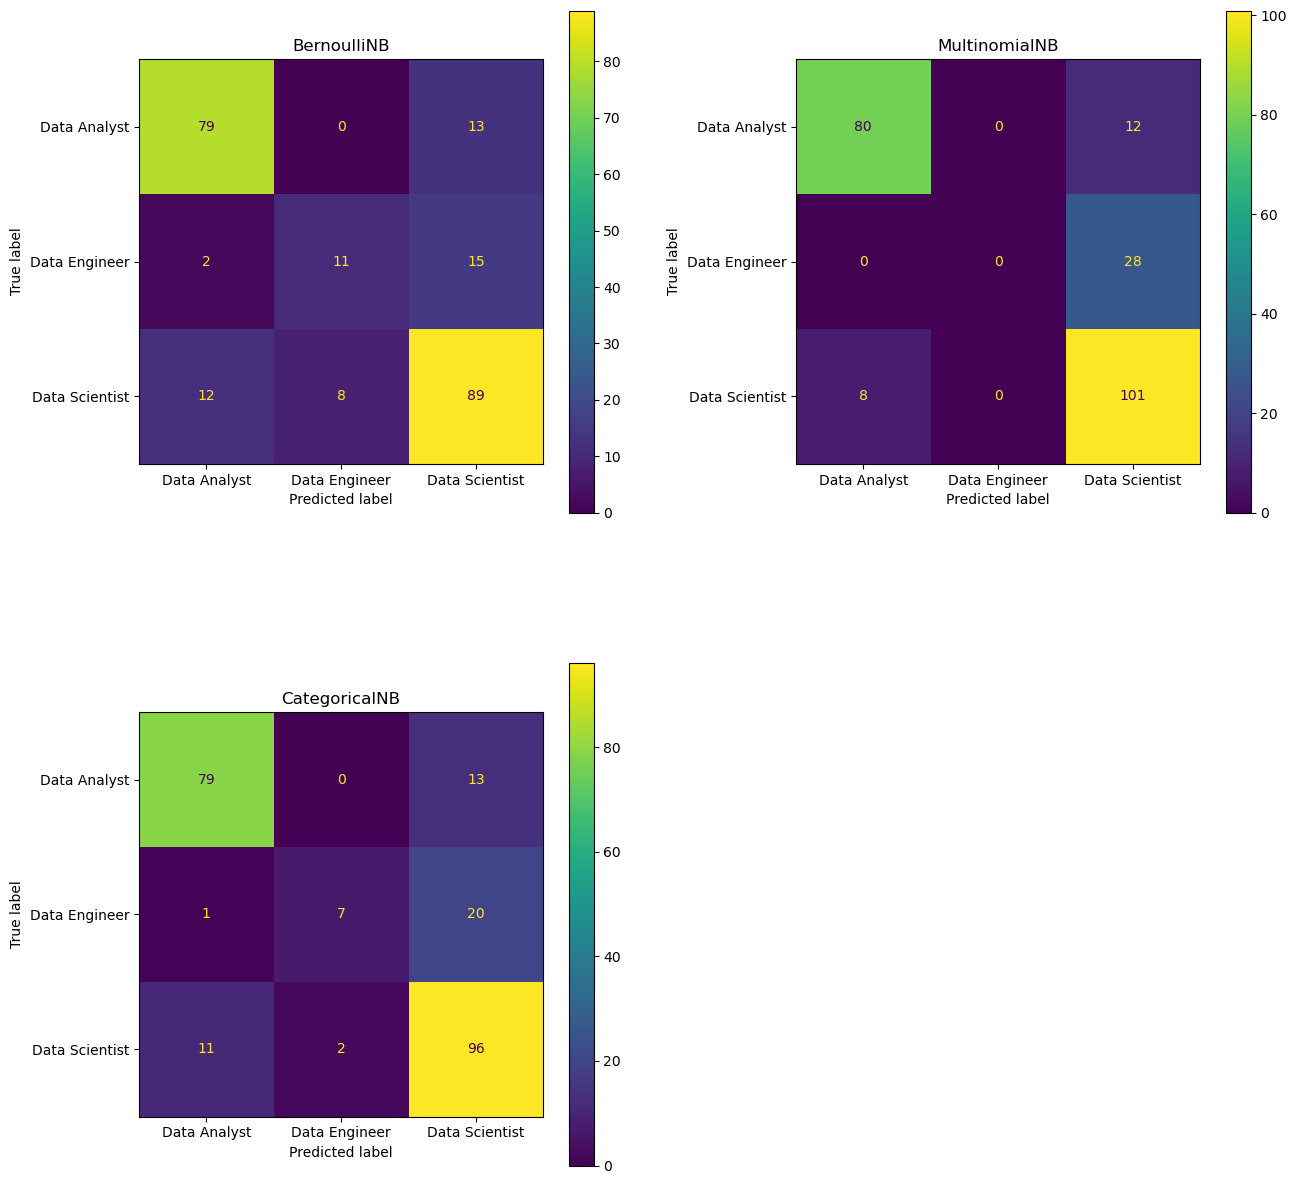

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, OrdinalEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load data
df = pd.read_csv('datasets/final_cleaned_data.csv')
print("\nOriginal Data Sample:")
print(df.head())

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(df['job_category'])

# Select features
features = ['python_yn', 'R_yn', 'spark', 'aws', 'excel', 'avg_salary']
X = df[features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =================================================================
# Common Preprocessing: Discretize avg_salary for all models
# =================================================================
# Create bin edges based on training data
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
salary_bins = discretizer.fit_transform(X_train[['avg_salary']])

# Apply same discretization to test data
X_train_discrete = discretizer.transform(X_train[['avg_salary']])
X_test_discrete = discretizer.transform(X_test[['avg_salary']])

# Update features
X_train_preprocessed = X_train.copy()
X_train_preprocessed['avg_salary'] = X_train_discrete
X_test_preprocessed = X_test.copy()
X_test_preprocessed['avg_salary'] = X_test_discrete

# =================================================================
# Model 1: BernoulliNB (Binary Features Only)
# =================================================================
print("\n" + "="*60)
print("BernoulliNB Model Preparation")
print("="*60)

bin_features = ['python_yn', 'R_yn', 'spark', 'aws', 'excel']
X_train_bnb = X_train[bin_features]
X_test_bnb = X_test[bin_features]

print("\nTraining Data (Binary Features):")
print(X_train_bnb.head())
print("\nTesting Data (Binary Features):")
print(X_test_bnb.head())

bnb = BernoulliNB(alpha=1.0)
scores_bnb = cross_val_score(bnb, X_train_bnb, y_train, 
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                           scoring='accuracy')
bnb.fit(X_train_bnb, y_train)
y_pred_bnb = bnb.predict(X_test_bnb)

# =================================================================
# Model 2: MultinomialNB (All Features with Discretization)
# =================================================================
print("\n" + "="*60)
print("MultinomialNB Model Preparation")
print("="*60)

print("\nTraining Data (Discretized Features):")
print(X_train_preprocessed.head())
print("\nTesting Data (Discretized Features):")
print(X_test_preprocessed.head())

pipeline_mnb = Pipeline([
    ('classifier', MultinomialNB())
])

param_grid_mnb = {
    'classifier__alpha': [0.1, 1.0, 10.0]
}

grid_mnb = GridSearchCV(pipeline_mnb, param_grid_mnb, 
                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                       scoring='accuracy')
grid_mnb.fit(X_train_preprocessed, y_train)
y_pred_mnb = grid_mnb.predict(X_test_preprocessed)

# =================================================================
# Model 3: CategoricalNB (Encoded Features)
# =================================================================
print("\n" + "="*60)
print("CategoricalNB Model Preparation")
print("="*60)

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
         ['python_yn', 'R_yn', 'spark', 'aws', 'excel']),
        ('num', 'passthrough', ['avg_salary'])
    ])

pipeline_cnb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', CategoricalNB())
])

X_train_ctnb = X_train.copy()
X_test_ctnb = X_test.copy()

print("\nTraining Data (Encoded Features):")
print(pd.DataFrame(preprocessor.fit_transform(X_train_ctnb), columns=features).head())
print("\nTesting Data (Encoded Features):")
print(pd.DataFrame(preprocessor.transform(X_test_ctnb), columns=features).head())

scores_cnb = cross_val_score(pipeline_cnb, X_train_ctnb, y_train,
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                            scoring='accuracy')
pipeline_cnb.fit(X_train_ctnb, y_train)
y_pred_cnb = pipeline_cnb.predict(X_test_ctnb)

# =================================================================
# Evaluation and Visualization
# =================================================================
# Create figure for confusion matrices
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# BernoulliNB Confusion Matrix
disp_bnb = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_bnb),
                                 display_labels=le.classes_)
disp_bnb.plot(ax=ax[0, 0])
ax[0, 0].set_title('BernoulliNB')

# MultinomialNB Confusion Matrix
disp_mnb = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_mnb),
                                 display_labels=le.classes_)
disp_mnb.plot(ax=ax[0, 1])
ax[0, 1].set_title('MultinomialNB')

# CategoricalNB Confusion Matrix
disp_cnb = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_cnb),
                                 display_labels=le.classes_)
disp_cnb.plot(ax=ax[1, 0])
ax[1, 0].set_title('CategoricalNB')

# Hide empty subplot
ax[1, 1].axis('off')

# Metrics calculation
def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")

# Print all metrics
print("\n" + "="*60)
print("Model Evaluation Metrics")
print("="*60)
print_metrics(y_test, y_pred_bnb, "BernoulliNB")
print_metrics(y_test, y_pred_mnb, "MultinomialNB")
print_metrics(y_test, y_pred_cnb, "CategoricalNB")

# Additional GridSearch results for MultinomialNB
print("\nMultinomialNB Best Parameters:", grid_mnb.best_params_)
print("MultinomialNB Best CV Accuracy:", grid_mnb.best_score_)

# Cross-validation scores
print("\nCross-Validation Scores:")
print(f"BernoulliNB Mean CV Accuracy: {np.mean(scores_bnb):.4f}")
print(f"CategoricalNB Mean CV Accuracy: {np.mean(scores_cnb):.4f}")

# Show all plots
plt.show()

c:\Users\shiva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


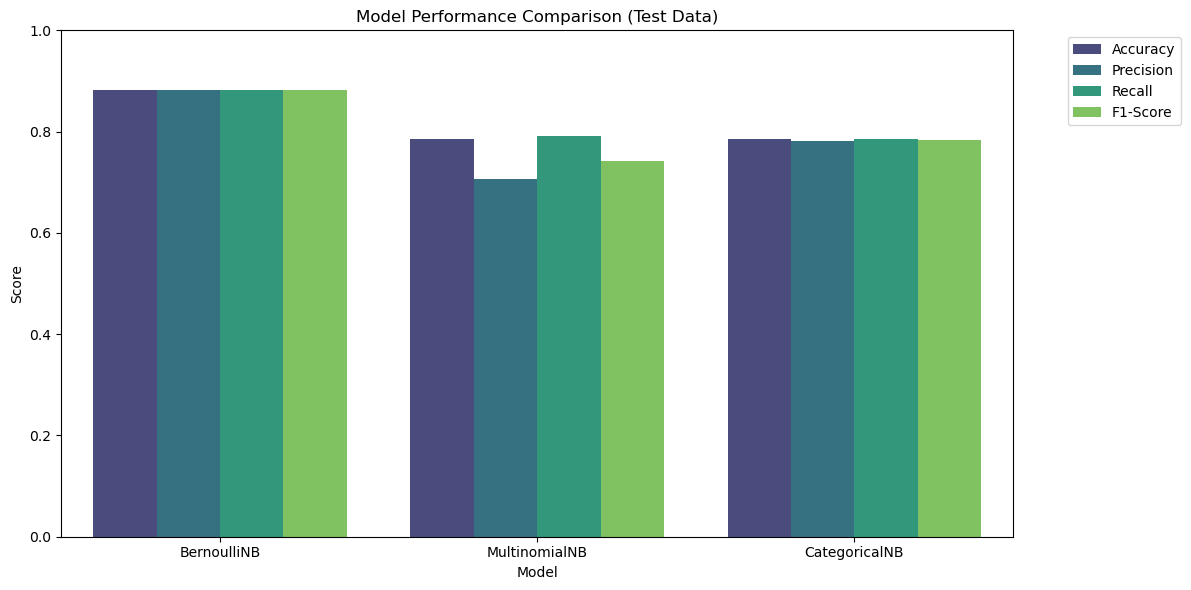

<Figure size 800x500 with 0 Axes>

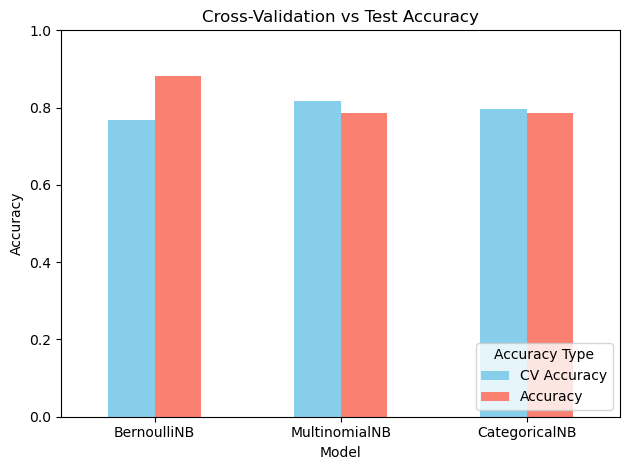

In [22]:
import seaborn as sns

# 1. Compute missing metrics for MultinomialNB and CategoricalNB
# For MultinomialNB
precision_mnb = precision_score(y_test, y_pred_mnb, average='weighted')
recall_mnb = recall_score(y_test, y_pred_mnb, average='weighted')
f1_mnb = f1_score(y_test, y_pred_mnb, average='weighted')

# For CategoricalNB
y_pred_cnb = grid_cnb.predict(X_test_enc)  # Ensure this is defined if not already
precision_cnb = precision_score(y_test, y_pred_cnb, average='weighted')
recall_cnb = recall_score(y_test, y_pred_cnb, average='weighted')
f1_cnb = f1_score(y_test, y_pred_cnb, average='weighted')

# 2. Create a DataFrame to store metrics
metrics_df = pd.DataFrame({
    'Model': ['BernoulliNB', 'MultinomialNB', 'CategoricalNB'],
    'Accuracy': [accuracy_bnb, accuracy_mnb, accuracy_cnb],
    'Precision': [precision_bnb, precision_mnb, precision_cnb],
    'Recall': [recall_bnb, recall_mnb, recall_cnb],
    'F1-Score': [f1_bnb, f1_mnb, f1_cnb],
    'CV Accuracy': [np.mean(scores), grid_mnb.best_score_, grid_cnb.best_score_]
})

# 3. Plot grouped bar chart for metrics
plt.figure(figsize=(12, 6))
metrics_df_melted = metrics_df.melt(id_vars='Model', value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'], 
                                    var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df_melted, palette='viridis')
plt.title('Model Performance Comparison (Test Data)')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4. Plot cross-validation vs test accuracy
plt.figure(figsize=(8, 5))
metrics_df[['Model', 'CV Accuracy', 'Accuracy']].set_index('Model').plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Cross-Validation vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title='Accuracy Type', loc='lower right')
plt.tight_layout()
plt.show()

## Decision Trees

Training Data Sample:
      python_yn  R_yn  spark  aws  excel  avg_salary
643         0.0   0.0    0.0  0.0    1.0    117500.0
722         0.0   0.0    0.0  0.0    1.0    221520.0
570         0.0   0.0    0.0  0.0    1.0     55120.0
66          0.0   0.0    0.0  0.0    1.0    117500.0
1003        0.0   0.0    0.0  0.0    0.0    290160.0
[0 1 2 0 2]
Testing Data Sample:
     python_yn  R_yn  spark  aws  excel  avg_salary
218        0.0   0.0    0.0  0.0    1.0    215280.0
809        0.0   0.0    0.0  0.0    1.0    127920.0
501        1.0   0.0    1.0  1.0    0.0    239200.0
649        1.0   0.0    0.0  0.0    0.0    212160.0
323        0.0   0.0    0.0  1.0    0.0    226720.0
[0 2 2 2 1]
Accuracy of Decision Tree 1 (Depth=3, MinSamplesSplit=2, Criterion=gini): 0.81


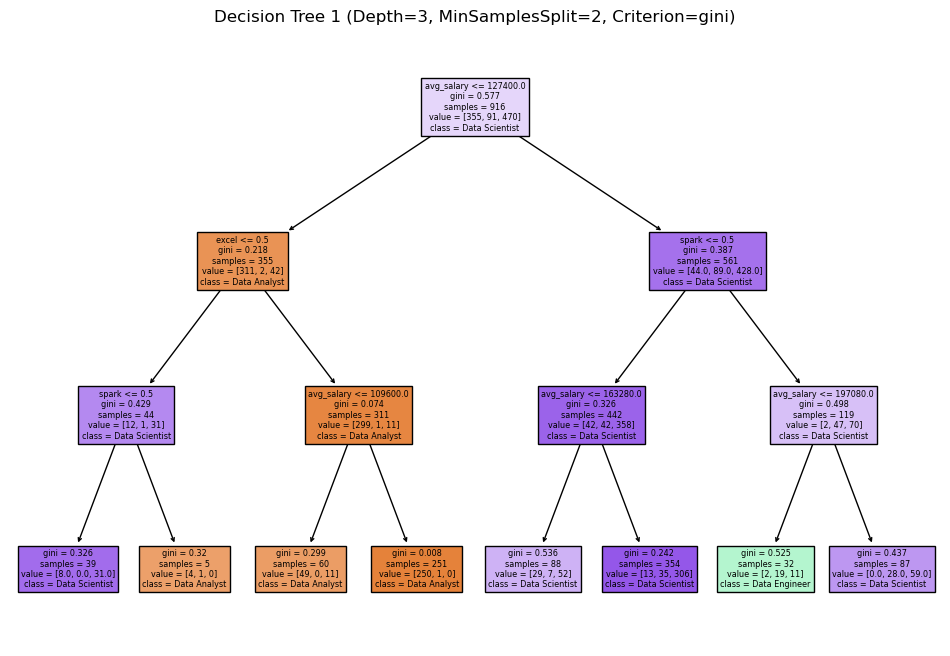

<Figure size 800x800 with 0 Axes>

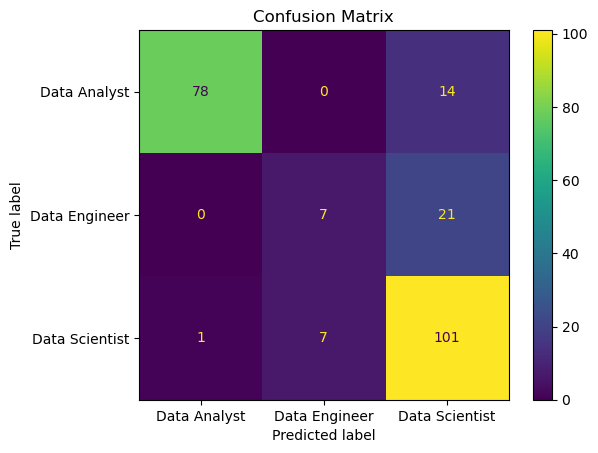

Accuracy of Decision Tree 2 (Depth=4, MinSamplesSplit=4, Criterion=gini): 0.79


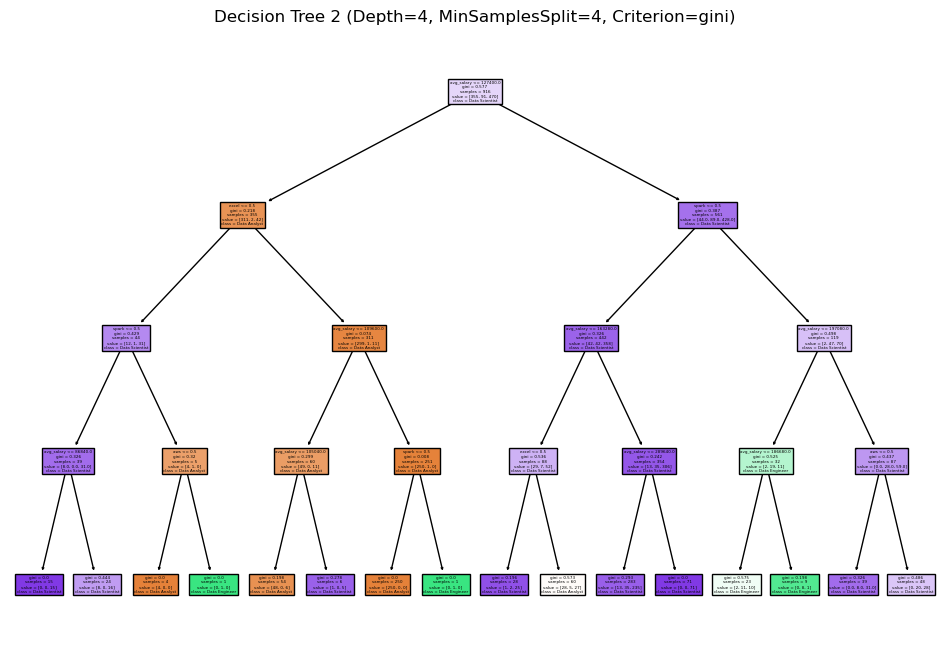

<Figure size 800x800 with 0 Axes>

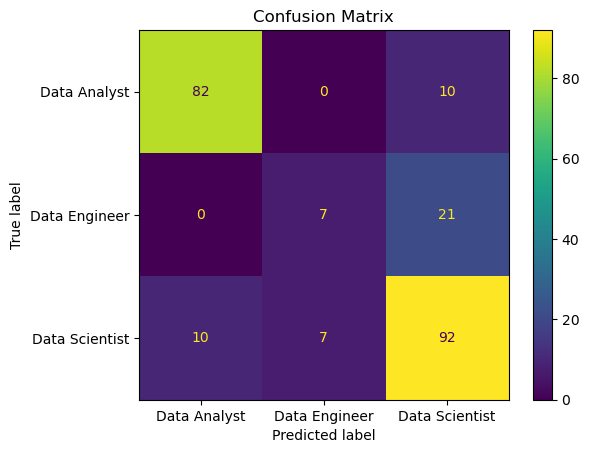

Accuracy of Decision Tree 3 (Depth=5, MinSamplesSplit=3, Criterion=entropy): 0.81


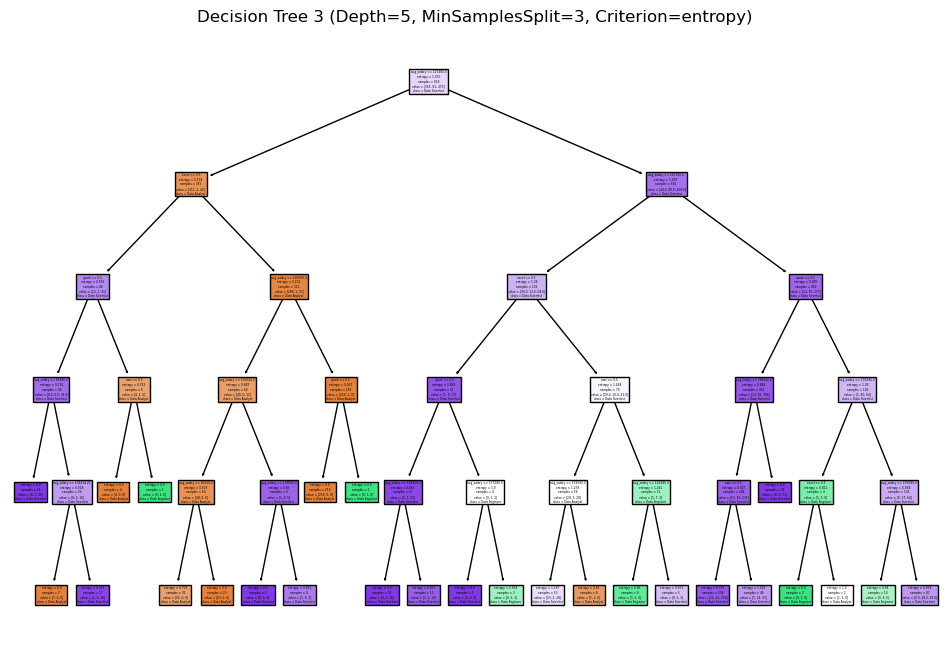

<Figure size 800x800 with 0 Axes>

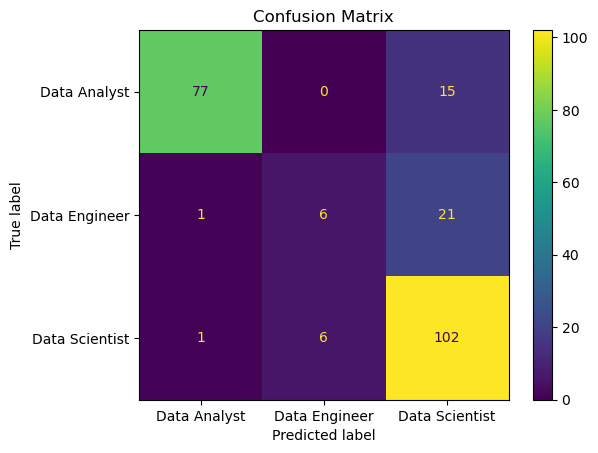

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Load data
df = pd.read_csv('datasets/final_cleaned_data.csv')

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(df['job_category'])

# Define feature sets to change the starting node
feature_sets = [
    ['avg_salary', 'python_yn', 'R_yn', 'spark', 'aws', 'excel'],  # Prioritize 'avg_salary'
    ['spark', 'aws', 'excel', 'python_yn', 'R_yn', 'avg_salary'],  # Prioritize 'spark'
    ['excel', 'aws', 'spark', 'R_yn', 'python_yn', 'avg_salary']   # Prioritize 'excel'
]

# Split data
X_train, X_test, y_train, y_test = train_test_split(df[features], y, test_size=0.2, random_state=42)

print("Training Data Sample:")
print(X_train.head())
print(y_train[:5])  # Prints the first 5 target values from the training set

print("Testing Data Sample:")
print(X_test.head())
print(y_test[:5])  # Prints the first 5 target values from the testing set

# Define different configurations for the Decision Tree
configurations = [
    {'max_depth': 3, 'min_samples_split': 2, 'criterion': 'gini'},
    {'max_depth': 4, 'min_samples_split': 4, 'criterion': 'gini'},
    {'max_depth': 5, 'min_samples_split': 3, 'criterion': 'entropy'}
]

# Generate and plot each tree with different configurations and feature sets
for i, (config, feature_set) in enumerate(zip(configurations, feature_sets)):
    X_train_selected = X_train[feature_set]
    X_test_selected = X_test[feature_set]
    
    dt = DecisionTreeClassifier(random_state=42, **config)
    dt.fit(X_train_selected, y_train)
    
    # Predict the labels on the test set
    y_pred = dt.predict(X_test_selected)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of Decision Tree {i+1} (Depth={config['max_depth']}, MinSamplesSplit={config['min_samples_split']}, Criterion={config['criterion']}): {accuracy:.2f}")
    
    # Plotting the decision tree
    plt.figure(figsize=(12, 8))
    plot_tree(dt, filled=True, feature_names=feature_set, class_names=np.unique(le.inverse_transform(y)).astype(str))
    plt.title(f"Decision Tree {i+1} (Depth={config['max_depth']}, MinSamplesSplit={config['min_samples_split']}, Criterion={config['criterion']})")
    plt.show()

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(le.inverse_transform(y)))
    plt.figure(figsize=(8, 8))
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()





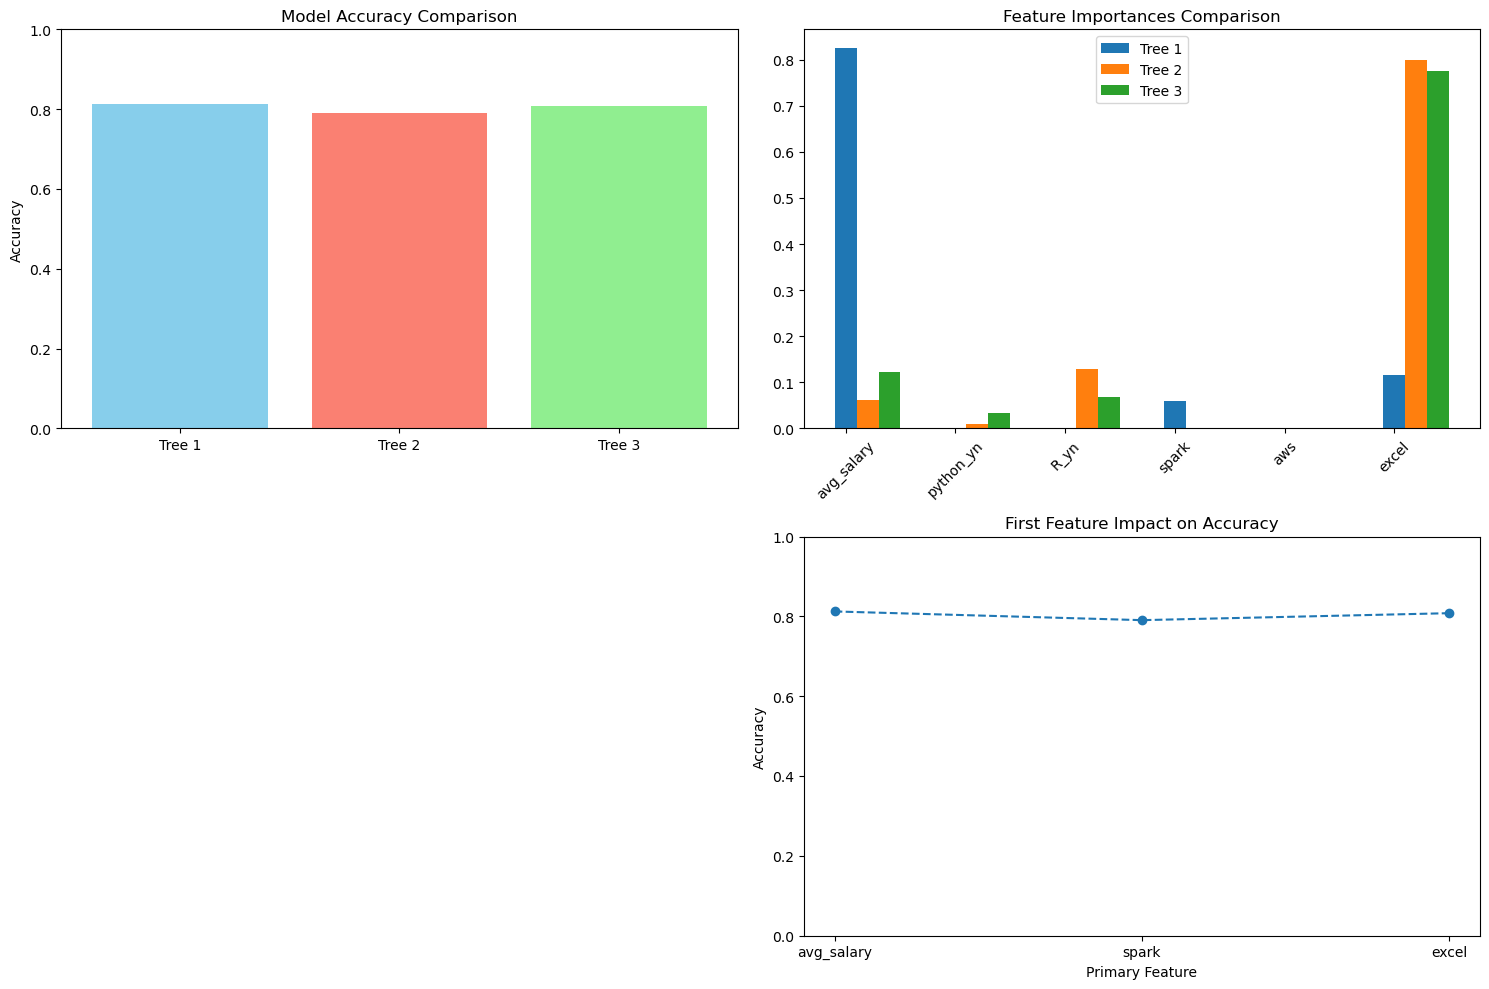

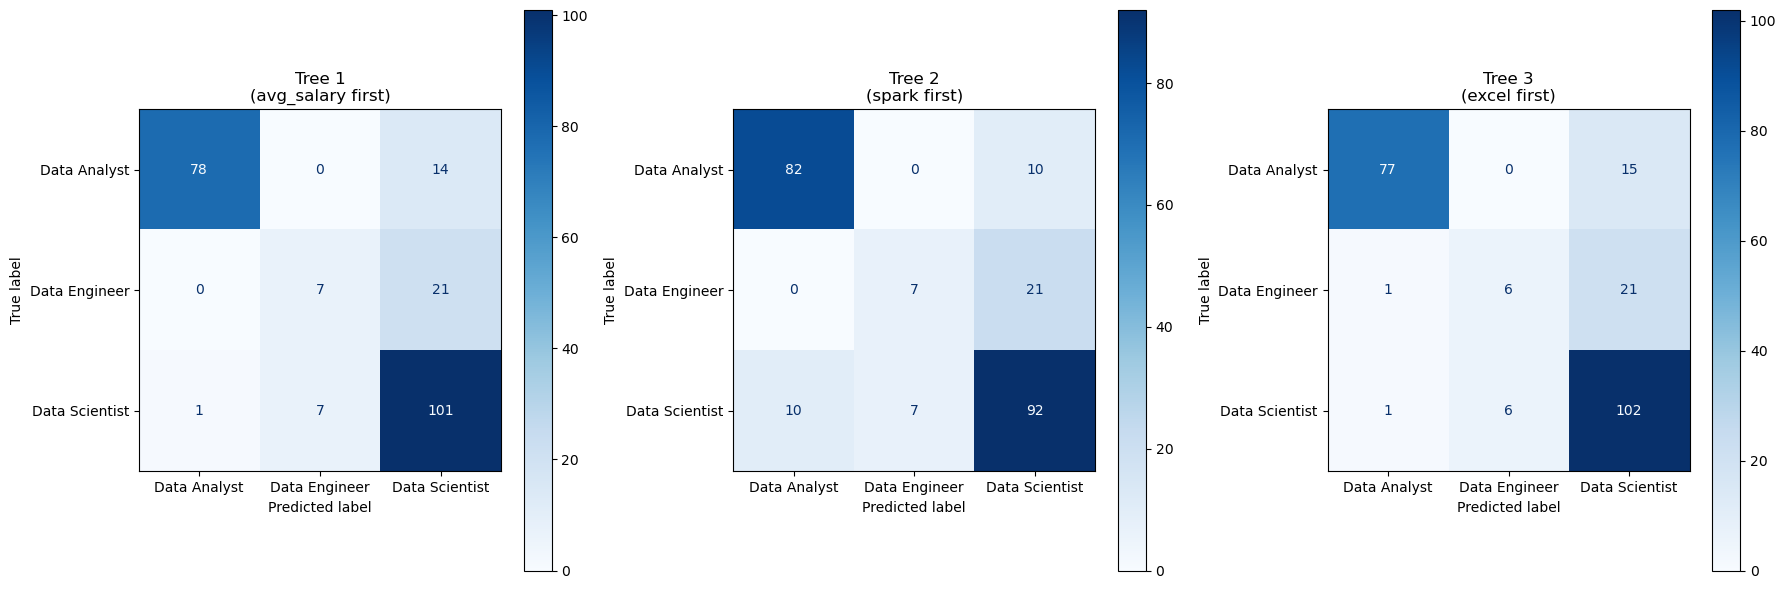

In [24]:
# ==== Comparative Visualization Code ====

# 1. Create a results storage dictionary
results = {
    'Tree': [],
    'Features': [],
    'Accuracy': [],
    'Depth': [],
    'Criterion': [],
    'MinSamplesSplit': [],
    'Feature Importances': []
}

# 2. Re-run models to collect metrics (or modify your existing loop to store these)
for i, (config, feature_set) in enumerate(zip(configurations, feature_sets)):
    X_train_selected = X_train[feature_set]
    X_test_selected = X_test[feature_set]
    
    dt = DecisionTreeClassifier(random_state=42, **config)
    dt.fit(X_train_selected, y_train)
    y_pred = dt.predict(X_test_selected)
    
    # Store results
    results['Tree'].append(f"Tree {i+1}")
    results['Features'].append(feature_set[0])  # Show primary feature
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Depth'].append(config['max_depth'])
    results['Criterion'].append(config['criterion'])
    results['MinSamplesSplit'].append(config['min_samples_split'])
    results['Feature Importances'].append(dt.feature_importances_)

# 3. Create comparison plots
plt.figure(figsize=(15, 10))

# Plot 1: Accuracy Comparison
plt.subplot(2, 2, 1)
plt.bar(results['Tree'], results['Accuracy'], color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

# Plot 2: Feature Importance Comparison
plt.subplot(2, 2, 2)
for i, (tree, importances) in enumerate(zip(results['Tree'], results['Feature Importances'])):
    plt.bar(np.arange(len(importances)) + i*0.2, importances, width=0.2, label=tree)
plt.title('Feature Importances Comparison')
plt.xticks(ticks=np.arange(len(feature_sets[0])), labels=feature_sets[0], rotation=45)
plt.legend()


# Plot 4: Feature Prioritization Impact
plt.subplot(2, 2, 4)
plt.plot(results['Features'], results['Accuracy'], marker='o', linestyle='--')
plt.title('First Feature Impact on Accuracy')
plt.xlabel('Primary Feature')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# 4. Confusion Matrix Grid
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, (tree, importances) in enumerate(zip(results['Tree'], results['Feature Importances'])):
    dt = DecisionTreeClassifier(random_state=42, **configurations[i]).fit(X_train[feature_sets[i]], y_train)
    y_pred = dt.predict(X_test[feature_sets[i]])
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[i], 
                                           display_labels=le.classes_, 
                                           cmap='Blues')
    ax[i].set_title(f'{tree}\n({feature_sets[i][0]} first)')
plt.tight_layout()
plt.show()

## Logistic Regression

Training Data Sample:
   python_yn     R_yn     spark       aws     excel  avg_salary
0  -0.800251 -0.04183 -0.413227 -0.426181  0.745457   -0.791880
1  -0.800251 -0.04183 -0.413227 -0.426181  0.745457    0.526349
2  -0.800251 -0.04183 -0.413227 -0.426181  0.745457   -1.582411
3  -0.800251 -0.04183 -0.413227 -0.426181  0.745457   -0.791880
4  -0.800251 -0.04183 -0.413227 -0.426181 -1.341459    1.396213
643     0
722     1
570     1
66      0
1003    1
Name: job_category, dtype: int64
Testing Data Sample:
   python_yn     R_yn     spark       aws     excel  avg_salary
0  -0.800251 -0.04183 -0.413227 -0.426181  0.745457    0.447271
1  -0.800251 -0.04183 -0.413227 -0.426181  0.745457   -0.659829
2   1.249608 -0.04183  2.419977  2.346419 -1.341459    0.750405
3   1.249608 -0.04183 -0.413227 -0.426181 -1.341459    0.407731
4  -0.800251 -0.04183 -0.413227  2.346419 -1.341459    0.592248
218    0
809    1
501    1
649    1
323    1
Name: job_category, dtype: int64


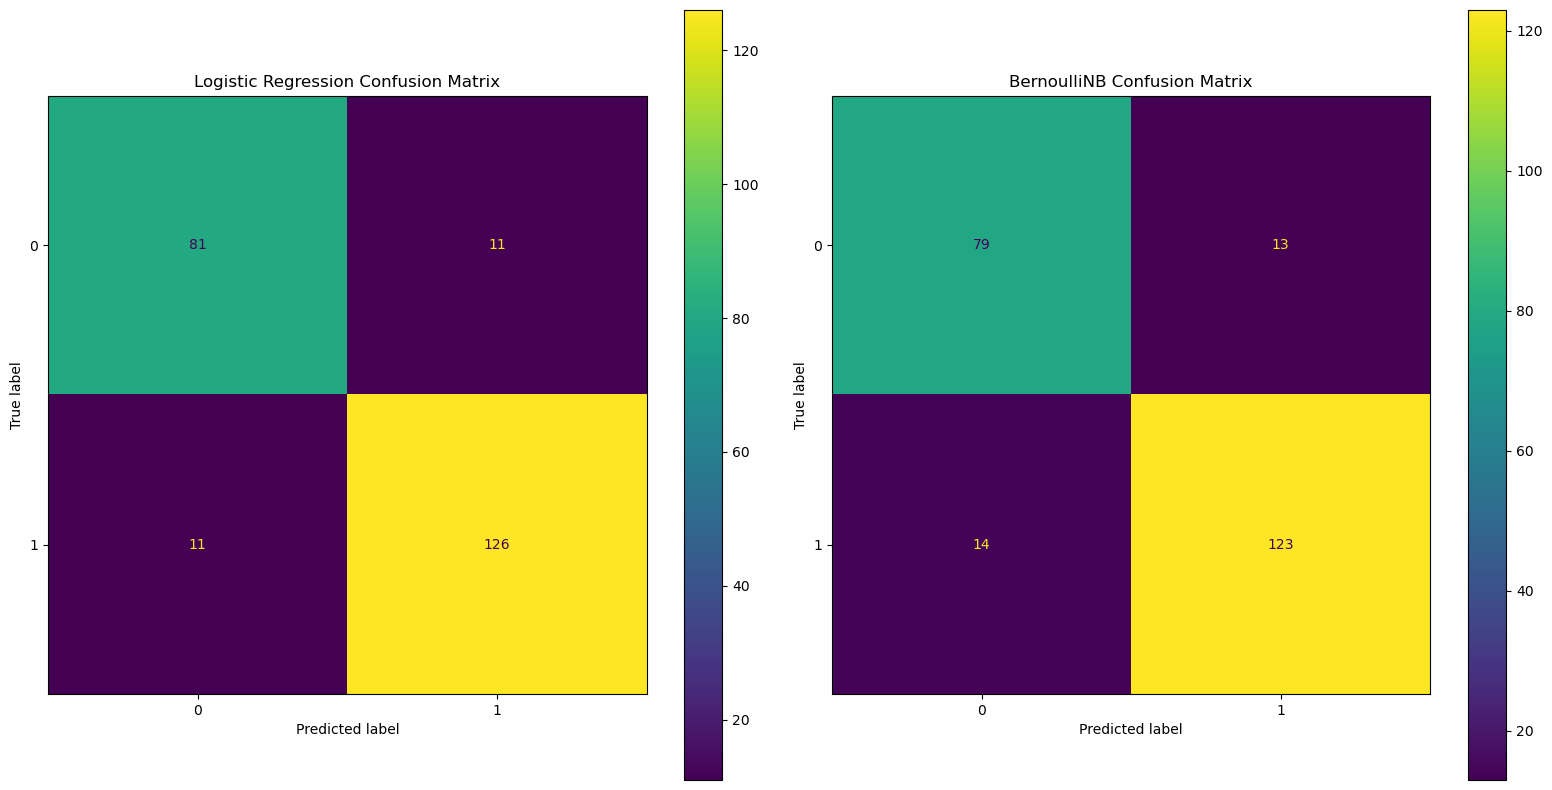

Logistic Regression Metrics:
Accuracy: 0.90, Precision: 0.90, Recall: 0.90, F1-Score: 0.90
BernoulliNB Metrics:
Accuracy: 0.88, Precision: 0.88, Recall: 0.88, F1-Score: 0.88


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Load data
df = pd.read_csv('datasets/final_cleaned_data.csv')

# Encode target variable
le = LabelEncoder()
df['job_category'] = df['job_category'].apply(lambda x: 0 if x == 'Data Analyst' else 1)
df['job_category'] = le.fit_transform(df['job_category'])

# Select features
features = ['python_yn', 'R_yn', 'spark', 'aws', 'excel', 'avg_salary']
X = df[features]
y = df['job_category']

# Scale features for Logistic Regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Optionally convert numpy arrays to DataFrame for better output formatting if needed
X_train_df = pd.DataFrame(X_train, columns=features)
X_test_df = pd.DataFrame(X_test, columns=features)

# Display training and testing data sample using DataFrame
print("Training Data Sample:")
print(X_train_df.head())
print(y_train[:5])  # Prints the first 5 target values from the training set

print("Testing Data Sample:")
print(X_test_df.head())
print(y_test[:5])  # Prints the first 5 target values from the testing set


# Model 1: Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Model 2: BernoulliNB (Using only binary features)
bnb = BernoulliNB()
X_train_binary = X_train[:, :5]  # Assuming the first five features are binary
X_test_binary = X_test[:, :5]
bnb.fit(X_train_binary, y_train)
y_pred_bnb = bnb.predict(X_test_binary)
accuracy_bnb = accuracy_score(y_test, y_pred_bnb)
precision_bnb = precision_score(y_test, y_pred_bnb, average='weighted')
recall_bnb = recall_score(y_test, y_pred_bnb, average='weighted')
f1_bnb = f1_score(y_test, y_pred_bnb, average='weighted')

# Set up subplot grid
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot confusion matrix for Logistic Regression
disp_lr = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_lr),
                                 display_labels=le.classes_)
disp_lr.plot(ax=ax[0])
ax[0].set_title('Logistic Regression Confusion Matrix')

# Plot confusion matrix for BernoulliNB
disp_bnb = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_bnb),
                                  display_labels=le.classes_)
disp_bnb.plot(ax=ax[1])
ax[1].set_title('BernoulliNB Confusion Matrix')

# Show plots
plt.tight_layout()
plt.show()

# Print accuracy and other metrics
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_lr:.2f}, Precision: {precision_lr:.2f}, Recall: {recall_lr:.2f}, F1-Score: {f1_lr:.2f}")
print("BernoulliNB Metrics:")
print(f"Accuracy: {accuracy_bnb:.2f}, Precision: {precision_bnb:.2f}, Recall: {recall_bnb:.2f}, F1-Score: {f1_bnb:.2f}")


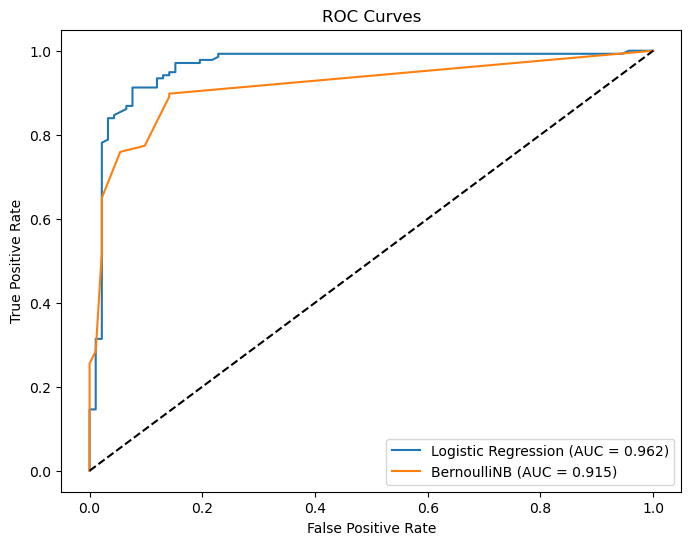

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate probabilities for Logistic Regression
lr_probs = log_reg.predict_proba(X_test)[:, 1]

# Calculate probabilities for BernoulliNB
bnb_probs = bnb.predict_proba(X_test_binary)[:, 1]

# Calculate ROC Curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
auc_lr = roc_auc_score(y_test, lr_probs)

# Calculate ROC Curve for BernoulliNB
fpr_bnb, tpr_bnb, _ = roc_curve(y_test, bnb_probs)
auc_bnb = roc_auc_score(y_test, bnb_probs)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_bnb, tpr_bnb, label=f'BernoulliNB (AUC = {auc_bnb:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()
